In [1]:
import pandas as pd
olympics = pd.read_csv('C:/Users/cm44/Desktop/host_country.csv',encoding="ISO-8859–1")
olympics1 = pd.read_csv('C:/Users/cm44/Desktop/athlete_events.csv',encoding="ISO-8859–1")
mergedframe = pd.merge(olympics1, olympics, left_on='City', right_on='Host City', how ='inner')
mergedframe.loc[:, ['Year_x', 'Host Country']].drop_duplicates().sort_values('Year_x')
import numpy as np
mergedframe['Medal'].fillna('DNW', inplace = True)
mergedframe['Medal_Won'] = np.where(mergedframe.loc[:,'Medal'] == 'DNW', 0, 1)
identify_team_events = pd.pivot_table(mergedframe,
                                      index = ['Team', 'Year_x', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1).reset_index()



identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]
team_sports = identify_team_events['Event'].unique()



remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar", 
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]
team_sports = list(set(team_sports) - set(remove_sports))



team_event_mask = mergedframe['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]



# rows where medal_won is 1
medal_mask = mergedframe['Medal_Won'] == 1



# Put 1 under team event if medal is won and event in team event list
mergedframe['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)




# Put 1 under singles event if medal is won and event not in team event list
mergedframe['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)




# Add an identifier for team/single event
mergedframe['Event_Category'] = mergedframe['Single_Event'] + mergedframe['Team_Event']
medal_tally_agnostic = mergedframe.groupby(['Year_x', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].agg('sum').reset_index()
medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']
top_countries = ['United States', 'Russia', 'Germany']
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in top_countries)



best_team_sports = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum',
                                  fill_value = 0).sort_values(['Team', 'Gold'], ascending = [True, False]).reset_index()

best_team_sports.drop(['Bronze', 'Silver', 'DNW'], axis = 1, inplace = True)
best_team_sports.columns = ['Team', 'Event', 'Gold_Medal_Count']
pd.set_option('display.max_columns', None) 
pd.options.display.max_rows = 999
best_team_sports.groupby('Team').head(10)

,Team,Event,Gold_Medal_Count
0,Germany,Luge Men's Singles,6
1,Germany,"Equestrianism Mixed Dressage, Team",5
2,Germany,Luge Women's Singles,5
3,Germany,Alpine Skiing Women's Combined,4
4,Germany,"Canoeing Men's Canadian Doubles, 1,000 metres",4
5,Germany,"Canoeing Men's Canadian Singles, 1,000 metres",4
6,Germany,"Canoeing Men's Kayak Doubles, 1,000 metres",4
7,Germany,"Canoeing Women's Kayak Doubles, 500 metres",4
8,Germany,"Equestrianism Mixed Jumping, Team",4
9,Germany,Rowing Men's Quadruple Sculls,4


In [2]:
medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']
# print(medal_tally_agnostic)
medal_tally = medal_tally_agnostic.groupby(['Year_x','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()
# x=mergedframe.drop(['ID','Sex','Age','Height','Weight','Year_y','Games','Event'],axis=1)
# pd.set_option('display.max_columns', None) 
# pd.options.display.max_rows = 999
# x.head(100)
y=mergedframe.drop(['ID','Sex','Age','Height','Weight','Year_y','Event'],axis=1)
y.rename(columns = {'Year_x':'Year'}, inplace = True)
medal_tally.head()
# y.head(200)
# z=y.groupby(['Season','Team'])['Name'].count()
# pd.set_option('display.max_columns', None) 
# pd.options.display.max_rows = 999
# z.head(200)
year_host_team = y[['Year', 'Host Country', 'Team','Season']].drop_duplicates()
#print(year_host_team)

# check rows where host country is the same as team
#print(year_host_team)
row_mask_4 = (year_host_team['Host Country'].str.strip() == year_host_team['Team'].str.strip())

# add years in the year_host_team to capture one previous and one later year
year_host_team['Prev_Year'] = year_host_team['Year'] - 4
year_host_team['Next_Year'] = year_host_team['Year'] + 4

# Subset only where host nation and team were the same
year_host_team = year_host_team[row_mask_4]

#print("asdf")
#year_host_team.columns
#medal_tally.columns

# Calculate the medals won in each year where a team played at home. merge year_host_team with medal_tally on year and team
year_host_team_medal = year_host_team.merge(medal_tally,
                                           left_on = ['Year', 'Team'],
                                           right_on = ['Year_x', 'Team'],
                                           how = 'left')
#print(medal_tally)
#print("asdf")
#print(year_host_team)

#print(year_host_team_medal)
year_host_team_medal.rename(columns = {'Medal_Won_Corrected' : 'Medal_Won_Host_Year'}, inplace = True)

# Calculate medals won by team in previous year
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Prev_Year', 'Team'],
                                                 right_on = ['Year_x', 'Team'],
                                                 how = 'left')
#print(year_host_team_medal)
year_host_team_medal.drop('Year_x_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Medal_Won_Corrected': 'Medal_Won_Prev_Year',
                                    'Year':'Year'}, inplace = True)

# # Calculate the medals won by the team the year after they hosted.
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Next_Year', 'Team'],
                                                 right_on = ['Year_x', 'Team'],
                                                 how = 'left')
#print(year_host_team_medal)
year_host_team_medal.drop('Year_x', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Year': 'Year',
                                       'Medal_Won_Corrected' : 'Medal_Won_Next_Year'}, inplace = True)

# # General formatting changes
year_host_team_medal.drop(['Prev_Year', 'Next_Year'], axis = 1, inplace = True)
year_host_team_medal.sort_values('Year', ascending = True, inplace = True)
year_host_team_medal.reset_index(inplace = True, drop = True)


# # column re-ordering
year_host_team_medal = year_host_team_medal.loc[:, ['Year', 'Host Country', 'Team', 'Season','Medal_Won_Prev_Year', 'Medal_Won_Host_Year', 'Medal_Won_Next_Year']]

year_host_team_medal

,Year,Host Country,Team,Season,Medal_Won_Prev_Year,Medal_Won_Host_Year,Medal_Won_Next_Year
0,1900,France,France,Summer,NaN,66.0,1.0
1,1904,United States,United States,Summer,45.0,193.0,46.0
2,1912,Sweden,Sweden,Summer,24.0,57.0,NaN
3,1924,France,France,Summer,NaN,39.0,24.0
4,1924,France,France,Winter,NaN,39.0,24.0
5,1928,Netherlands,Netherlands,Summer,10.0,22.0,8.0
6,1932,United States,United States,Summer,56.0,114.0,59.0
7,1932,United States,United States,Winter,56.0,114.0,59.0
8,1936,Germany,Germany,Winter,25.0,103.0,NaN
9,1936,Germany,Germany,Summer,25.0,103.0,NaN


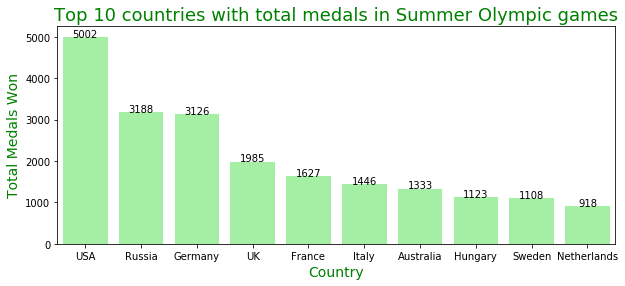

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
olympics2= pd.read_csv('C:/Users/cm44/Desktop/athlete_events.csv')
noc = pd.read_csv('C:/Users/cm44/Desktop/noc_regions.csv')
noc['region'].fillna(noc['notes'], inplace=True)
olympics2['Medal'] = olympics2['Medal'].fillna('No Medal')
player = olympics2.merge(noc, how='left', on='NOC')
#print(athlete)
top10_summer = player[(olympics2['Season']=='Summer') & (player['Medal']!='No Medal')].groupby('region').count().reset_index()[['region','Medal']].sort_values('Medal', ascending=False).head(10)
f, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="region", y="Medal", data=top10_summer, label="region", color="palegreen")

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2,p.get_height(),
            
            '{:1.0f}'.format(p.get_height()),
            ha="center")

ax.set_xlabel('Country', size=14, color="green")
ax.set_ylabel('Total Medals Won', size=14, color="green")
ax.set_title('Top 10 countries with total medals in Summer Olympic games', size=18, color="green")
plt.show()

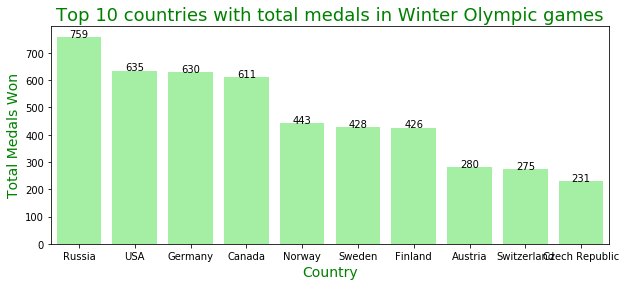

In [8]:
top10_winter = player[(olympics2['Season']=='Winter') & (player['Medal']!='No Medal')].groupby('region').count().reset_index()[['region','Medal']].sort_values('Medal', ascending=False).head(10)
f, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="region", y="Medal", data=top10_winter, label="region", color="palegreen")

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2,p.get_height(),
            
            '{:1.0f}'.format(p.get_height()),
            ha="center")

ax.set_xlabel('Country', size=14, color="green")
ax.set_ylabel('Total Medals Won', size=14, color="green")
ax.set_title('Top 10 countries with total medals in Winter Olympic games', size=18, color="green")
plt.show()

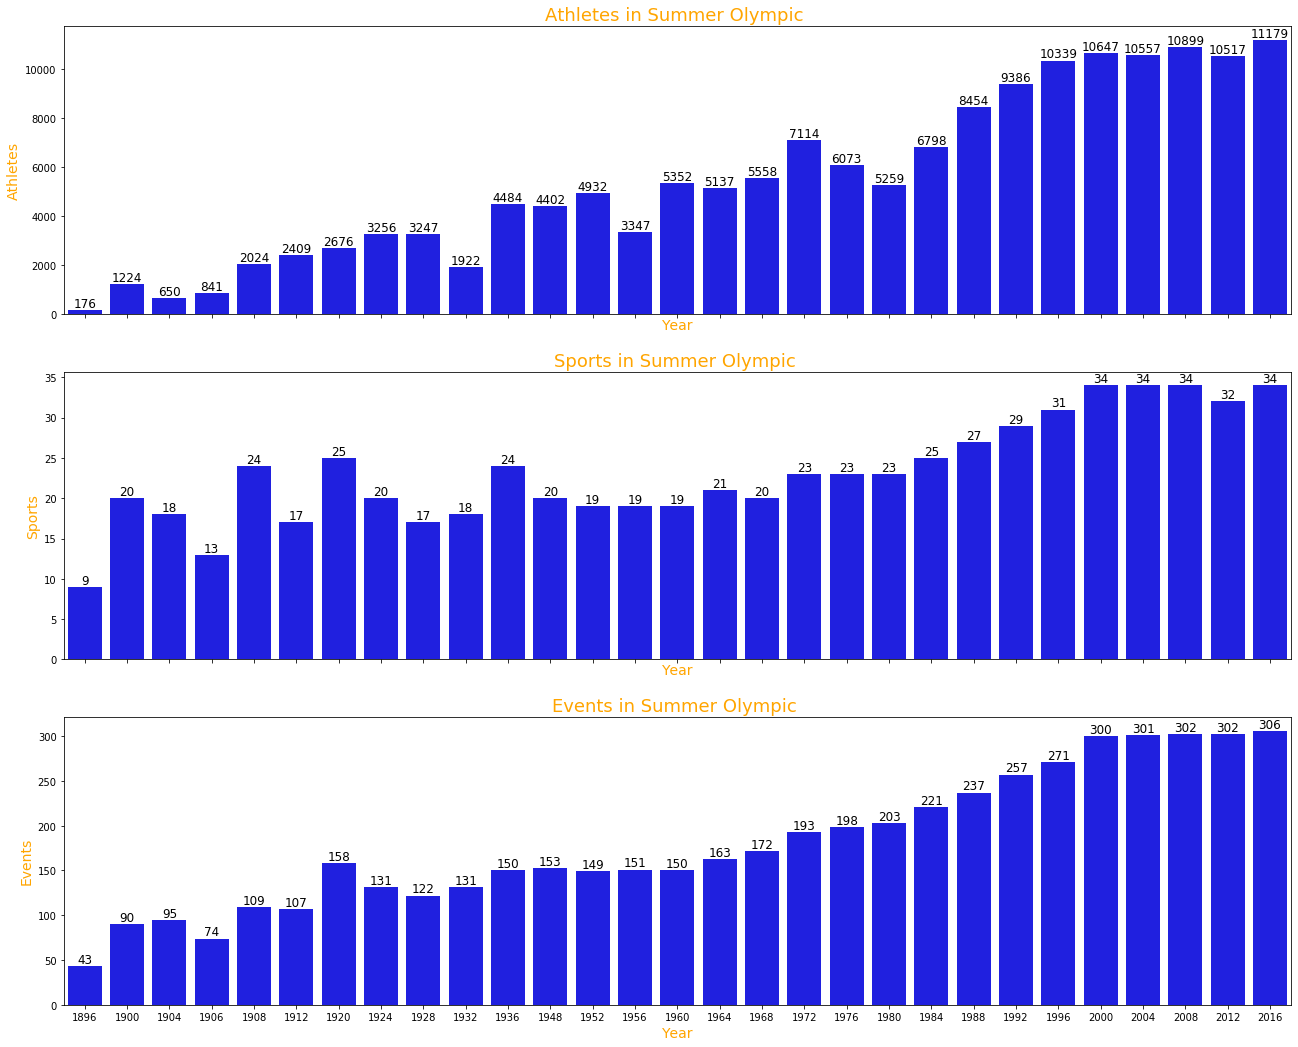

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


summerData = olympics2[olympics2['Season']=='Summer']

summerAthletes = summerData.pivot_table(summerData, index=['Year'], aggfunc=lambda x: len(x.unique())).reset_index()[['Year','ID']]
summerSports = summerData.groupby('Year')['Sport'].nunique().reset_index()
summerEvents = summerData.groupby('Year')['Event'].nunique().reset_index()

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(22,18))

sns.barplot(x='Year', y='ID', data=summerAthletes, ax=ax[0], color="blue")
sns.barplot(x='Year', y='Sport', data=summerSports, ax=ax[1], color="blue")
sns.barplot(x='Year', y='Event', data=summerEvents, ax=ax[2], color="blue")

j = 0
for i in ['Athletes', 'Sports', 'Events']:
    ax[j].set_xlabel('Year', size=14, color="orange")
    ax[j].set_ylabel(i, size=14, color="orange")
    ax[j].set_title(i + ' in Summer Olympic ', size=18, color="orange")
    j = j + 1
    
for i in range(3):
    for p in ax[i].patches:
        ax[i].text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
                fontsize=12, color='black', ha='center', va='bottom')
plt.show()

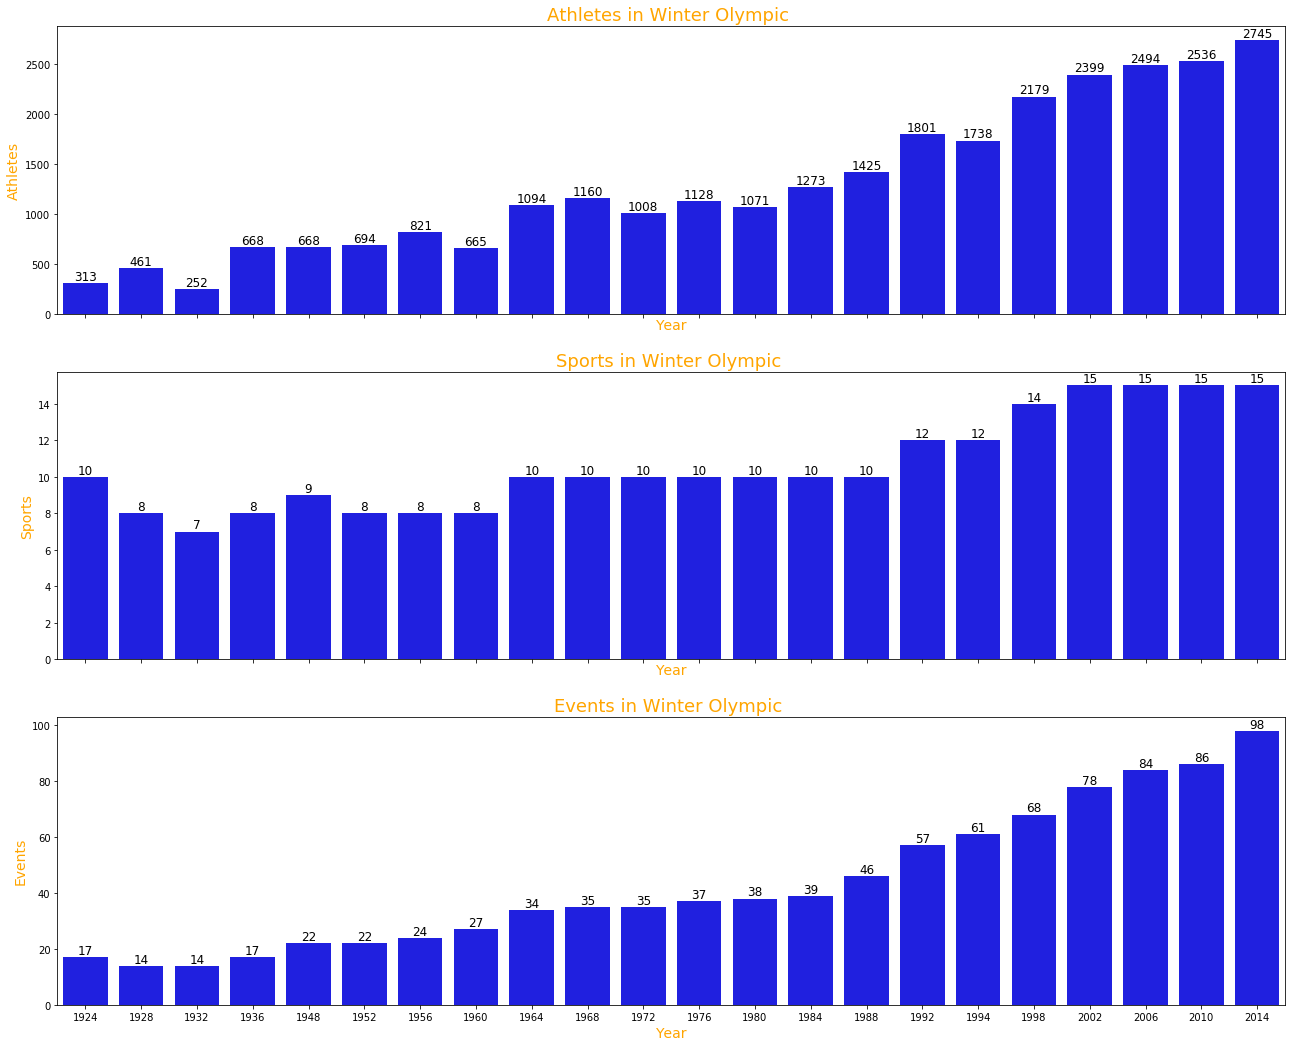

In [10]:



winterData = olympics2[olympics2['Season']=='Winter']

winterAthletes = winterData.pivot_table(winterData, index=['Year'], aggfunc=lambda x: len(x.unique())).reset_index()[['Year','ID']]
winterSports = winterData.groupby('Year')['Sport'].nunique().reset_index()
winterEvents = winterData.groupby('Year')['Event'].nunique().reset_index()

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(22,18))

sns.barplot(x='Year', y='ID', data=winterAthletes, ax=ax[0], color="blue")
sns.barplot(x='Year', y='Sport', data=winterSports, ax=ax[1], color="blue")
sns.barplot(x='Year', y='Event', data=winterEvents, ax=ax[2], color="blue")

j = 0
for i in ['Athletes', 'Sports', 'Events']:
    ax[j].set_xlabel('Year', size=14, color="orange")
    ax[j].set_ylabel(i, size=14, color="orange")
    ax[j].set_title(i + ' in Winter Olympic ', size=18, color="orange")
    j = j + 1
    
for i in range(3):
    for p in ax[i].patches:
        ax[i].text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
                fontsize=12, color='black', ha='center', va='bottom')
plt.show()

In [ ]:
year_team_gdp = olympics_complete_subset.loc[:, ['Year', 'Team', 'GDP']].drop_duplicates()

medal_tally_gdp = medal_tally.merge(year_team_gdp,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   how = 'left')

row_mask_5 = medal_tally_gdp['Medal_Won_Corrected'] > 0
row_mask_6 = medal_tally_gdp['Team'].map(lambda x: x in top_countries)

correlation = medal_tally_gdp.loc[row_mask_5, ['GDP', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]

plot(medal_tally_gdp.loc[row_mask_5, 'GDP'], 
     medal_tally_gdp.loc[row_mask_5, 'Medal_Won_Corrected'] , 
     linestyle = 'none', 
     marker = 'o',
    alpha = 0.4)
xlabel('Country GDP')

ylabel('Number of Medals')
title('GDP versus medal tally')
text(np.nanpercentile(medal_tally_gdp['GDP'], 99.6), 
     max(medal_tally_gdp['Medal_Won_Corrected']) - 50,
     "Correlation = " + str(correlation))